<a href="https://colab.research.google.com/github/Adarsh-Vemali/Numerical_linear_algebra/blob/main/gcn_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tkipf/gcn/tree/master/gcn/data


Cloning into 'data'...
fatal: repository 'https://github.com/tkipf/gcn/tree/master/gcn/data/' not found


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# #**Add python version you wish** to list
# !sudo apt-get update -y
# !sudo add-apt-repository ppa:deadsnakes/ppa -y
# !sudo apt-get update -y
# !sudo apt-get install python3.7
# !sudo apt install python3.7-distutils
# from IPython.display import clear_output
# clear_output()
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1

# # Choose one of the given alternatives:
# !sudo update-alternatives --config python3

# # This one used to work but now NOT(for me)!
# # !sudo update-alternatives --config python

# # Check the result
# !python3 --version

# # Attention: Install pip (... needed!)
# !sudo apt install python3-pip

In [4]:
!pip3 install -r /content/drive/MyDrive/gcn/requirements.txt

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import sys

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
def uniform(shape, scale=0.05, name=None):
    """Uniform init."""
    initial = tf.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def glorot(shape, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def zeros(shape, name=None):
    """All zeros."""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def ones(shape, name=None):
    """All ones."""
    initial = tf.ones(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

In [7]:
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str, basedir=''):
    """
    Loads input data from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open(basedir+"data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    print("ou rprint statemetn", x,y,tx,ty,allx,ally,graph)
    test_idx_reorder = parse_index_file(basedir+"data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]



    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)

In [8]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}


def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs."""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]


def sparse_dropout(x, keep_prob, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)


def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res


class Layer(object):
    """Base layer class. Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).

    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.summary.histogram(self.name + '/inputs', inputs)
            outputs = self._call(inputs)
            if self.logging:
                tf.summary.histogram(self.name + '/outputs', outputs)
            return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.summary.histogram(self.name + '/vars/' + var, self.vars[var])


class Dense(Layer):
    """Dense layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0., sparse_inputs=False,
                 act=tf.nn.relu, bias=False, featureless=False, **kwargs):
        super(Dense, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = glorot([input_dim, output_dim],
                                          name='weights')
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # transform
        output = dot(x, self.vars['weights'], sparse=self.sparse_inputs)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)


class GraphConvolution(Layer):
    """Graph convolution layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0.,
                 sparse_inputs=False, act=tf.nn.relu, bias=False,
                 featureless=False, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.support = placeholders['support']
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            for i in range(len(self.support)):
                self.vars['weights_' + str(i)] = glorot([input_dim, output_dim],
                                                        name='weights_' + str(i))
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # convolve
        supports = list()
        for i in range(len(self.support)):
            if not self.featureless:
                pre_sup = dot(x, self.vars['weights_' + str(i)],
                              sparse=self.sparse_inputs)
            else:
                pre_sup = self.vars['weights_' + str(i)]
            support = dot(self.support[i], pre_sup, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)

In [9]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [10]:
class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1])
            self.activations.append(hidden)
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def save(self, sess=None, basedirpath=''):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, basedirpath+"tmp/%s.ckpt" % self.name)
        print("Model saved in file: %s" % save_path)

    def load(self, sess=None, basedirpath=''):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = basedirpath+"tmp/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)


class GCN(Model):
    def __init__(self, placeholders, input_dim, weight_decay, hidden1, learning_rate, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders
        self.weightdecay = weight_decay
        self.hidden1 = hidden1

        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += self.weightdecay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=self.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=self.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [11]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys

In [12]:
sys.argv = sys.argv[:1]
sys.argv

['/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py']

In [13]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)
sys.argv = sys.argv[:1]

# Settings
FLAGS = {}
FLAGS['dataset'] = 'cora'
FLAGS['model'] = 'gcn'
FLAGS['learning_rate'] = 0.01
FLAGS['epochs'] = 200
FLAGS['hidden1'] = 16
FLAGS['dropout'] = 0.5
FLAGS['weight_decay'] = 5e-4
FLAGS['early_stopping'] = 10
FLAGS['max_degree'] = 3


In [14]:
# Load data
adj, features, y_test, y_val, y_train, test_mask, val_mask, train_mask = load_data(FLAGS['dataset'], '/content/drive/MyDrive/gcn/')


<ipython-input-7-89d9b73b9fb2>:41: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  objects.append(pkl.load(f, encoding='latin1'))


ou rprint statemetn   (0, 19)	1.0
  (0, 81)	1.0
  (0, 146)	1.0
  (0, 315)	1.0
  (0, 774)	1.0
  (0, 877)	1.0
  (0, 1194)	1.0
  (0, 1247)	1.0
  (0, 1274)	1.0
  (1, 19)	1.0
  (1, 88)	1.0
  (1, 149)	1.0
  (1, 212)	1.0
  (1, 233)	1.0
  (1, 332)	1.0
  (1, 336)	1.0
  (1, 359)	1.0
  (1, 472)	1.0
  (1, 507)	1.0
  (1, 548)	1.0
  (1, 687)	1.0
  (1, 763)	1.0
  (1, 808)	1.0
  (1, 889)	1.0
  (1, 1058)	1.0
  :	:
  (138, 1263)	1.0
  (138, 1274)	1.0
  (138, 1290)	1.0
  (138, 1307)	1.0
  (138, 1406)	1.0
  (139, 1)	1.0
  (139, 41)	1.0
  (139, 187)	1.0
  (139, 212)	1.0
  (139, 357)	1.0
  (139, 404)	1.0
  (139, 464)	1.0
  (139, 505)	1.0
  (139, 507)	1.0
  (139, 581)	1.0
  (139, 635)	1.0
  (139, 874)	1.0
  (139, 988)	1.0
  (139, 1071)	1.0
  (139, 1230)	1.0
  (139, 1231)	1.0
  (139, 1258)	1.0
  (139, 1263)	1.0
  (139, 1274)	1.0
  (139, 1393)	1.0 [[0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 

<ipython-input-7-89d9b73b9fb2>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(mask, dtype=np.bool)


In [15]:
features

<2708x1433 sparse matrix of type '<class 'numpy.float32'>'
	with 49216 stored elements in List of Lists format>

In [16]:
features[0].shape

(1, 1433)

In [17]:
features[1].shape

(1, 1433)

In [18]:
1

1

In [19]:
train_mask.shape

(2708,)

In [20]:
features = preprocess_features(features)

In [21]:
support = [preprocess_adj(adj)]
num_supports = 1
model_func = GCN

In [22]:
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

In [23]:
model = model_func(placeholders, input_dim=features[2][1], weight_decay=FLAGS['weight_decay'], hidden1=FLAGS['hidden1'], learning_rate=FLAGS['learning_rate'], logging=True)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [24]:
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

training_curves = []

In [25]:
t1 = time.time()
for epoch in range(FLAGS['epochs']):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS['dropout']})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t), flush=True)

    training_curves.append((outs[1], outs[2], cost, acc)) # train_loss, train_acc, val_loss, val_acc

    if epoch > FLAGS['early_stopping'] and training_curves[-1][2] > np.mean([x[2] for x in training_curves][-(FLAGS['early_stopping']+1):-1]):
        print("Early stopping...")
        break
t2 = time.time()
print(t2-t1)
print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95312 train_acc= 0.13700 val_loss= 1.94669 val_acc= 0.22600 time= 8.08129
Epoch: 0002 train_loss= 1.94595 train_acc= 0.29100 val_loss= 1.93999 val_acc= 0.38400 time= 0.01877
Epoch: 0003 train_loss= 1.93925 train_acc= 0.38200 val_loss= 1.93308 val_acc= 0.43600 time= 0.01703
Epoch: 0004 train_loss= 1.93113 train_acc= 0.46300 val_loss= 1.92590 val_acc= 0.46800 time= 0.01517
Epoch: 0005 train_loss= 1.92368 train_acc= 0.47600 val_loss= 1.91843 val_acc= 0.49000 time= 0.02368
Epoch: 0006 train_loss= 1.91678 train_acc= 0.48900 val_loss= 1.91090 val_acc= 0.50000 time= 0.01425
Epoch: 0007 train_loss= 1.90808 train_acc= 0.49900 val_loss= 1.90350 val_acc= 0.53200 time= 0.01718
Epoch: 0008 train_loss= 1.89987 train_acc= 0.52800 val_loss= 1.89603 val_acc= 0.54200 time= 0.01172
Epoch: 0009 train_loss= 1.89286 train_acc= 0.51100 val_loss= 1.88825 val_acc= 0.54200 time= 0.02242
Epoch: 0010 train_loss= 1.88481 train_acc= 0.53100 val_loss= 1.88018 val_acc= 0.55000 time= 0.02810


In [40]:
evaluate(features, support, y_test, test_mask, placeholders)

(0.81123805, 0.86428577, 0.007134675979614258)

In [41]:
train_mask, val_mask, test_mask

(array([False, False, False, ...,  True,  True,  True]),
 array([False, False, False, ..., False, False, False]),
 array([ True,  True,  True, ..., False, False, False]))

In [42]:
train_mask.sum(),val_mask.sum(),test_mask.sum()

(1000, 500, 140)

In [43]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [51]:
your_feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)

# Assuming `model` is an instance of your GCN model
# Assuming `sess` is your TensorFlow session

# Get the node embeddings
node_embeddings = sess.run(model.activations[-2], feed_dict=your_feed_dict)

In [52]:
# Assuming `your_labels` is a NumPy array with labels for each node
# You can use these labels to color the points in the plot
your_labels = sess.run(model.placeholders['labels'], feed_dict=your_feed_dict)

In [53]:
node_embeddings = np.array([node_embeddings[i] for i in range(node_embeddings.shape[0]) if test_mask[i]])
node_embeddings.shape

(140, 16)

In [54]:
your_labels = np.array([your_labels[i] for i in range(your_labels.shape[0]) if test_mask[i]])
your_labels.shape

(140, 7)

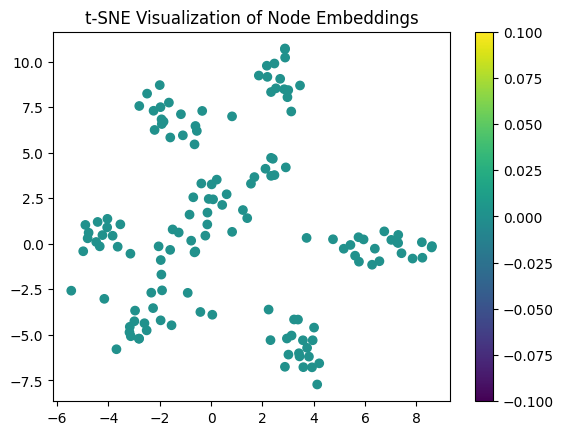

In [55]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings)

# Plot the 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=np.argmax(your_labels, axis=1), cmap='viridis')
plt.title('t-SNE Visualization of Node Embeddings')
plt.colorbar()
plt.show()


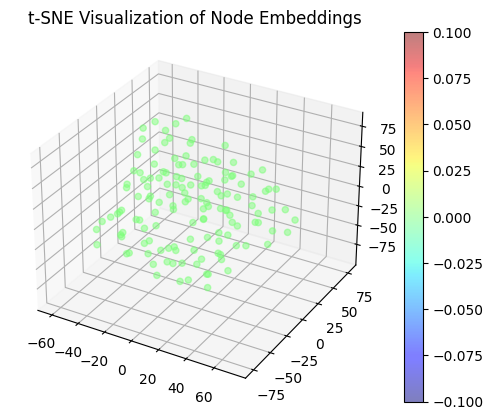

In [56]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(node_embeddings)

# Plot the 3D embeddings
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=np.argmax(your_labels, axis=1), cmap='jet', alpha=0.5)
ax.set_title('t-SNE Visualization of Node Embeddings')
fig.colorbar(scatter)
plt.show()


In [57]:
t1 = time.time()
predictions = sess.run(model.predict(), feed_dict=your_feed_dict)
t2 = time.time()
print(t2-t1)
predictions = np.array([predictions[i] for i in range(predictions.shape[0]) if train_mask[i]])
predictions.shape

0.11438679695129395


(1000, 7)

In [58]:
your_labels

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
 

In [59]:
predictions

array([[0.08340568, 0.07639242, 0.23604168, ..., 0.04012814, 0.09658164,
        0.05074138],
       [0.02600637, 0.02443179, 0.8292813 , ..., 0.01471764, 0.01260253,
        0.02307981],
       [0.02186271, 0.05900017, 0.64648557, ..., 0.0184242 , 0.01598511,
        0.01272278],
       ...,
       [0.07943922, 0.086907  , 0.02115684, ..., 0.01410033, 0.04970444,
        0.01292892],
       [0.01461817, 0.00916777, 0.01289794, ..., 0.02235312, 0.00302023,
        0.00135717],
       [0.01581118, 0.01059771, 0.0142341 , ..., 0.02321161, 0.00364809,
        0.00159624]], dtype=float32)

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Assuming `true` and `pred` are your true labels and predicted probabilities, respectively
true_labels = np.argmax(your_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))

ValueError: ignored